In [1]:
options(warn = -1, tidyverse.quiet = T)

library(tidyverse, warn.conflicts = F, quietly = T)
library(arrow, warn.conflicts = F)
library(cowplot, warn.conflicts = F)
library(yardstick, warn.conflicts = F)
library(scattermore)
library(colorspace)

In [2]:
feature_phenotypes <- c(
    "Alzheimer's" = "b_G30",
    "Cerebral infarction" = "b_I63",
    "Acute myocardial infarction" = "b_I21",
    "Essential hypertension" = "b_I10",
    "Obesity" = "b_E66",
    "Acute ischemic heart disease" = "b_I24",
    "Ischemic heart disease" = "b_I25",
    "Pulmonary heart diseases" = "b_I27",
    "Other heart disease" = "b_I51",
    "Other cerebrovascular" = "b_I67",
    "Type 1 diabetes mellitus" = "b_E10",
    "Type 2 diabetes mellitus" = "b_E11",
    "HbA1c" = "q_30750_0",
    "HDL cholesterol" = "q_30760_0",
    "Glucose" = "q_30740_0",
    "Cholesterol" = "q_30690_0",
    "Triglycerides" = "q_30870_0",
    "Lipoprotein A" = "q_30790_0",
    "Apolipoprotein B" = "q_30640_0",
    "Creatinine" = "q_30700_0"
)
reversed_feature_phenotypes = names(feature_phenotypes) %>% set_names(feature_phenotypes)

In [3]:
naive_df <- read_tsv("data/pheno/naive.tsv", show_col_types = F, 
                     col_types = cols(.default = col_double()))

maxgcp_df <- read_tsv("data/pheno/maxgcp.tsv", show_col_types = F, 
                      col_types = cols(.default = col_double()))

merged_df <- naive_df %>%
    inner_join(maxgcp_df, by = c("FID", "IID")) %>%
    select(-contains("sub"))

merged_df %>% head(0)

FID,IID,b_E10,b_E11,b_E66,b_G30,b_I10,b_I21,b_I24,b_I25,⋯,b_I67,q_30640_0,q_30690_0,q_30700_0,q_30740_0,q_30750_0,q_30760_0,q_30790_0,q_30870_0,maxgcp_full
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


# Reverse approach

In [4]:
lm_df <- merged_df %>%
    mutate(across(starts_with(c("b_", "q_")), ~scale(.) %>% as.double)) %>%
    pivot_longer(starts_with("maxgcp"), names_to = "maxgcp_type", values_to = "maxgcp") %>%
    select(maxgcp_type, maxgcp, starts_with("b_"), starts_with("q_")) %>%
    nest(data = -maxgcp_type) %>%
    rowwise() %>%
    mutate(
        reg = lm(maxgcp ~ . + 0, data = data) %>%
            broom::tidy() %>%
            list
    ) %>%
    select(-data) %>%
    unnest(reg)

lm_df %>% head(2)

maxgcp_type,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
maxgcp_full,b_E10,-1.242322,0.07667869,-16.20166,5.163794e-59
maxgcp_full,b_E11,1.048689,0.08717218,12.03009,2.507585e-33


In [5]:
plot_df <- lm_df %>%
    filter(term != "(Intercept)") %>%
    arrange(maxgcp_type, desc(estimate)) %>%
    mutate(
        phenotype = maxgcp_type %>% recode(maxgcp_full = "Full"),
        term = term %>% recode(!!!reversed_feature_phenotypes)
    ) %>%
    select(term, phenotype, estimate)

plot_df %>% head(2)

term,phenotype,estimate
<chr>,<chr>,<dbl>
Alzheimer's,Full,4.655978
Type 2 diabetes mellitus,Full,1.048689


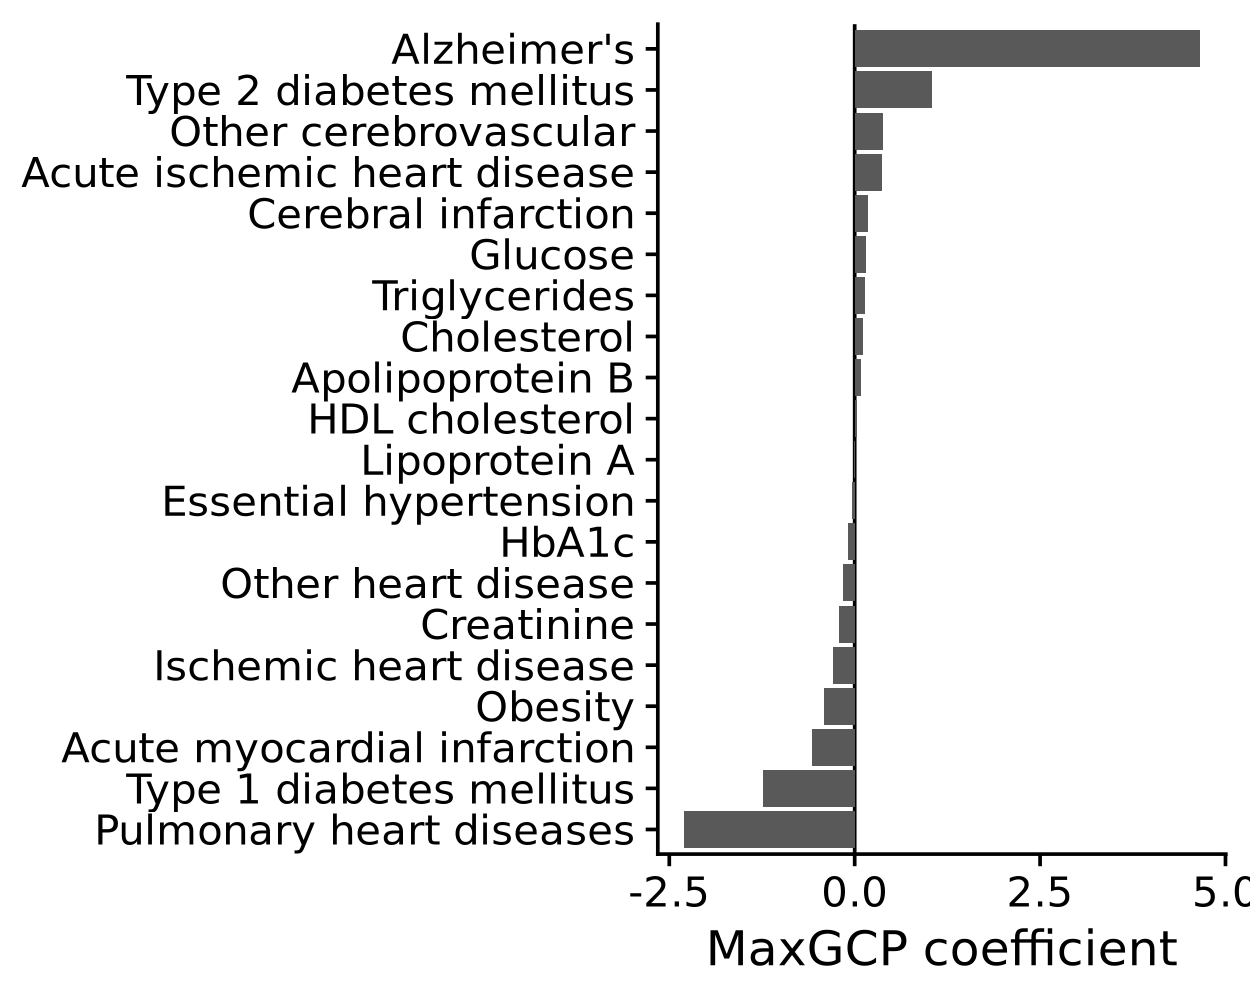

In [6]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 250)

plot_df %>%
    mutate(term = fct_reorder(term, estimate)) %>%
    ggplot(aes(y = term, x = estimate)) +
    geom_vline(xintercept = 0) +
    geom_col() +
    xlab("MaxGCP coefficient") +
    theme_cowplot() +
    theme(axis.title.y = element_blank())

# Forward approach

In [7]:
pcov_df <- read_tsv("data/pcov/naive_full.tsv", show_col_types = F, name_repair = "unique_quiet") %>%
    rename(phenotype1 = `...1`) %>%
    pivot_longer(-phenotype1, names_to = "phenotype2", values_to = "pcov")

pcov_df  %>% head(2)

phenotype1,phenotype2,pcov
<chr>,<chr>,<dbl>
b_E10,b_E10,0.009821947
b_E10,b_E11,0.006666513


In [8]:
gcov_df <- read_tsv("data/gcov/igap.naive.tsv", show_col_types = F) %>%
    filter(!str_detect(phenotype_id, "sub"))

gcov_df %>% head(2)

Component,Value,SD,phenotype_id
<chr>,<dbl>,<dbl>,<chr>
Her1_All,0.064306,0.014335,b_E10
Her2_All,0.024711,0.017961,b_E10


In [9]:
filtered_gcov_df <- gcov_df %>%
    filter(Component == "Her2_All", Value >= 0, Value <= 1) %>%
    distinct(phenotype_id) %>%
    inner_join(gcov_df, by = "phenotype_id") %>%
    filter(Component == "Cor_All", Value >= -1, Value <= 1) %>%
    distinct(phenotype_id) %>%
    inner_join(gcov_df, by = c("phenotype_id")) %>%
    filter(Component == "Coher_All") %>%
    select(-Component)

In [10]:
compute_maxgcp <- function(dataframe) {
    features <- dataframe$phenotype_id
    
    this_df <- dataframe %>%
        inner_join(pcov_df, by = c("phenotype_id" = "phenotype1")) %>%
        pivot_wider(names_from = phenotype2, values_from = pcov)

    X <- this_df %>% 
        as.data.frame %>%
        column_to_rownames("phenotype_id") %>%
        as.matrix %>%
        {
            .[features, c("gcov", features)]
        }

    y <- X[, "gcov"]
    X <- X[, features]
    
    beta <- solve(X, y)
    beta <- beta / sqrt(beta %*% X %*% beta)
    beta <- beta %>% set_names(names(y))
    beta
}

In [11]:
maxgcp_coef_df <- filtered_gcov_df %>%
    select(phenotype_id, gcov = Value) %>%
    compute_maxgcp %>%
    as_tibble_row %>%
    pivot_longer(everything(), names_to = "feature") %>%
    mutate(feature = feature %>% recode(!!!reversed_feature_phenotypes)) %>%
    select(feature, value)

maxgcp_coef_df %>% write_parquet("plot_data/maxgcp_coef.parquet")

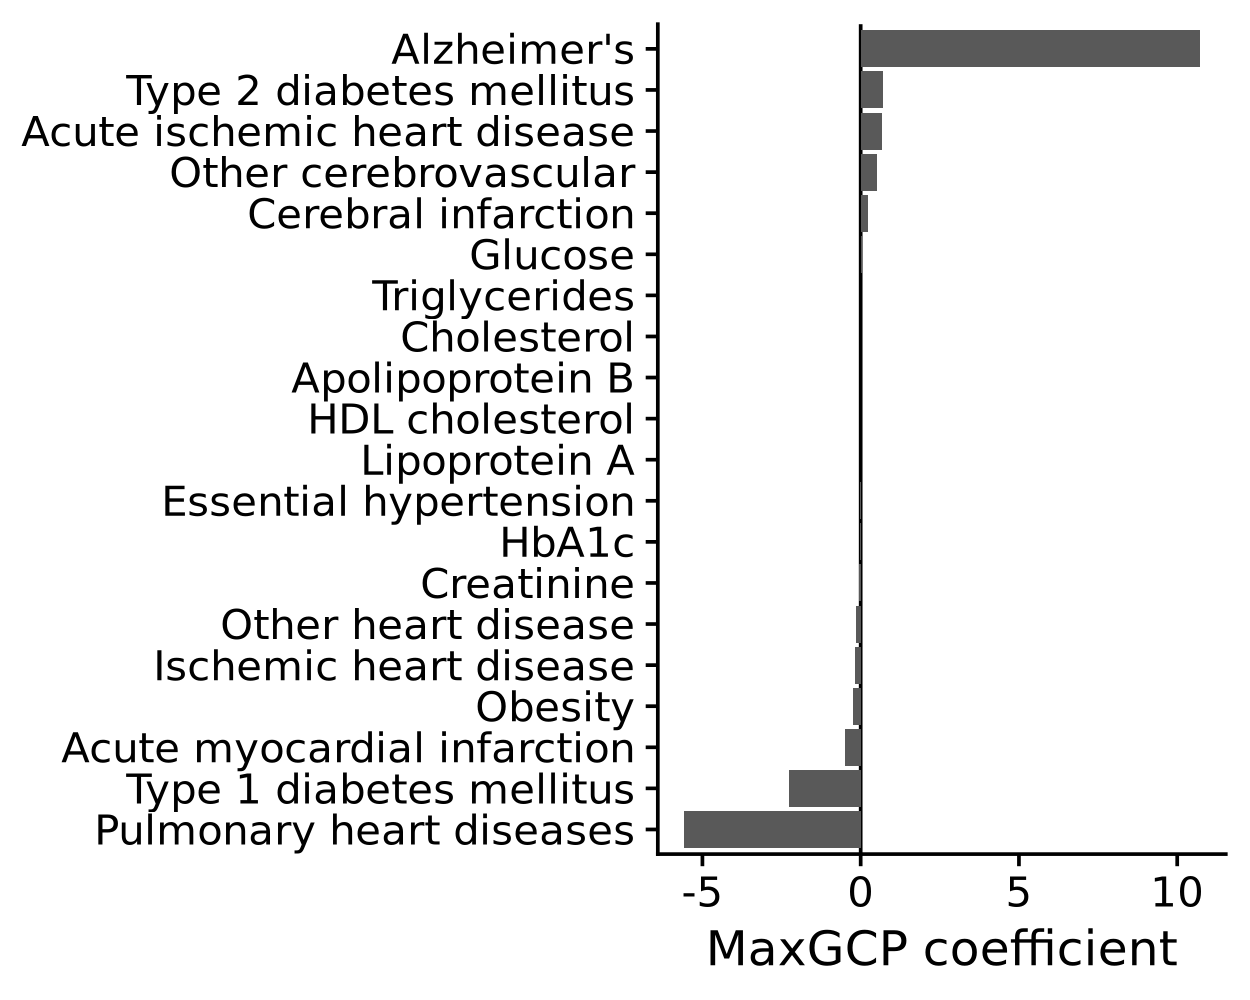

In [12]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 250)

coef_plot <- maxgcp_coef_df %>%
    mutate(feature = fct_reorder(feature, value)) %>%
    ggplot(aes(y = feature, x = value)) +
    geom_vline(xintercept = 0) +
    geom_col() +
    xlab("MaxGCP coefficient") +
    theme_cowplot() +
    theme(axis.title.y = element_blank())

save_plot("img/maxgcp_coef.png", coef_plot, base_width = 5, base_height = 4, 
          dpi = 400, bg = "white")

coef_plot

# Plot top features vs phenotypes

In [13]:
feature_phenotypes

Alzheimer's          Cerebral infarction 
                     "b_G30"                      "b_I63" 
 Acute myocardial infarction       Essential hypertension 
                     "b_I21"                      "b_I10" 
                     Obesity Acute ischemic heart disease 
                     "b_E66"                      "b_I24" 
      Ischemic heart disease     Pulmonary heart diseases 
                     "b_I25"                      "b_I27" 
         Other heart disease        Other cerebrovascular 
                     "b_I51"                      "b_I67" 
    Type 1 diabetes mellitus     Type 2 diabetes mellitus 
                     "b_E10"                      "b_E11" 
                       HbA1c              HDL cholesterol 
                 "q_30750_0"                  "q_30760_0" 
                     Glucose                  Cholesterol 
                 "q_30740_0"                  "q_30690_0" 
               Triglycerides                Lipoprotein A 
                 "q_30870_0"                  "q_30790_0" 
            Apolipoprotein B                   Creatinine 
                 "q_30640_0"                  "q_30700_0"

In [14]:
plot_df <- merged_df %>%
    select(IID, starts_with("b_"), starts_with("maxgcp_")) %>%
    mutate(
        across(starts_with("b_"), ~recode_factor(. - 2, `1` = "Case", `0` = "Control")),
        across(starts_with("maxgcp_"), ~scale(.) %>% as.double)
    ) %>%
    pivot_longer(starts_with("b_"), names_to = "naive_phenotype", values_to = "naive_value") %>%
    mutate(
        naive_phenotype = naive_phenotype %>% 
            recode(!!!reversed_feature_phenotypes),
    ) %>%
    inner_join(maxgcp_coef_df, by = c("naive_phenotype" = "feature")) %>%
    mutate(naive_phenotype = fct_reorder(naive_phenotype, value)) %>%
    select(-value)

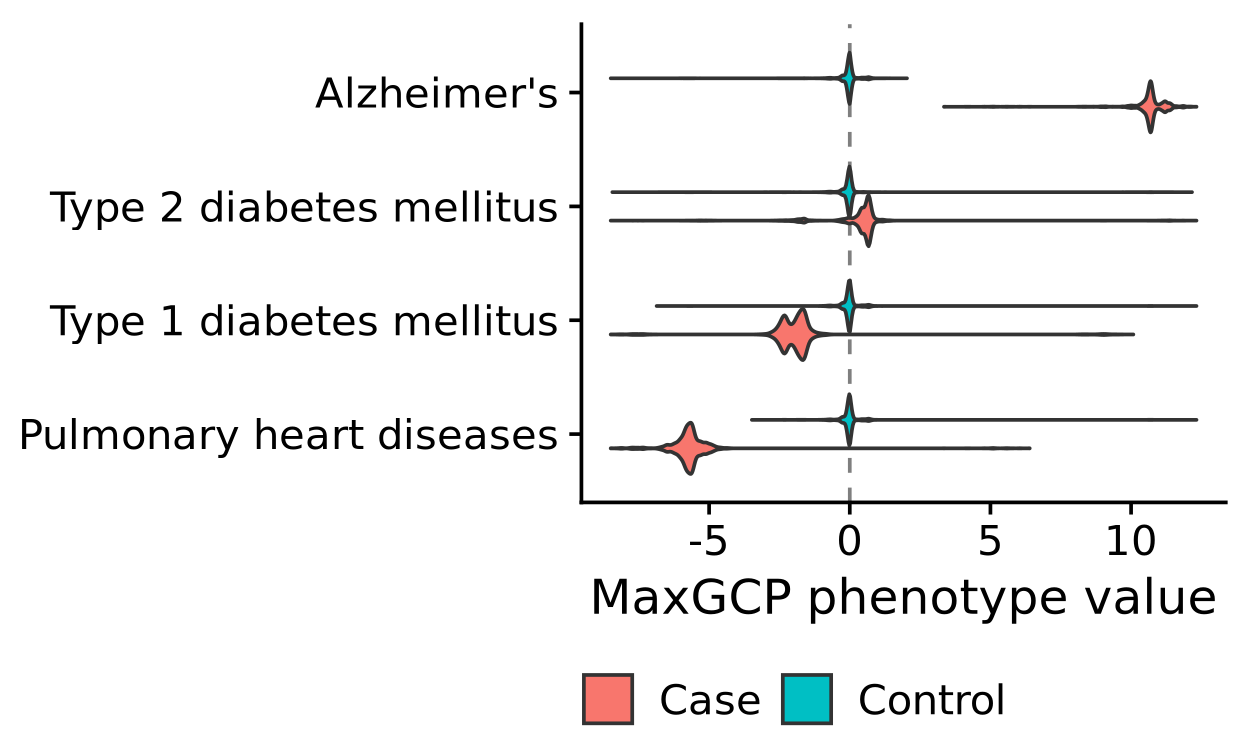

In [15]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 250)

top_features_plot <- plot_df %>%
    filter(
        naive_phenotype %in% c("Alzheimer's", "Type 2 diabetes mellitus", 
                               "Type 1 diabetes mellitus", "Pulmonary heart diseases")
    ) %>%
    ggplot(aes(y = naive_phenotype, x = maxgcp_full, fill = naive_value)) +
    geom_vline(xintercept = 0, color = "grey50", linetype = "dashed") +
    geom_violin(scale = "width", position = position_dodge(width = 0.5)) +
    xlab("MaxGCP phenotype value") +
    theme_cowplot() +
    theme(
        strip.background = element_blank(),
        legend.position = "bottom",
        axis.title.y = element_blank()
    ) +
    guides(fill = guide_legend(title = NULL))

save_plot("img/top_features.png", top_features_plot, base_width = 5, base_height = 3, 
          dpi = 400, bg = "white")

top_features_plot